Neural Net from Scratch
=======================

In [1]:
import numpy as np
from itertools import starmap, cycle
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

from IPython.display import clear_output, display

def show(thing):
    clear_output()
    display(thing)
    
from numpy.random import RandomState
random = RandomState(0)

My network is a list of numpy 1D arrays for the neuron layers and 2D arrays for connection weights. The first neuron layer is the input and the last one will be the output. In between a layer with `n` neurons and one with `m` I define the weights as a 2D array of shape `(n, m)`. We can fully define the network by the list of weights which I'll name `net`.

In [2]:
def rand_net(shape=[2, 3, 1]):
    "Generate random weights for a network of the given shape."
    return [random.normal(size=(l, r)) for l, r in zip(shape[:-1], shape[1:])]

In [3]:
# I define my sigmoid function to map to (-1, +1).
sigmoid = np.vectorize(lambda x: 2.0/(1+np.exp(-x)) - 1.0)

# The derivative of the sigmoid.
d_sigmoid = np.vectorize(lambda x: 2.0*np.exp(-x) / (1.0 + np.exp(-x))**2)

# Compute the derivative from the limit so we can test it.
d_sigmoid2 = np.vectorize(lambda x: (sigmoid(x+1e-6) - sigmoid(x)) / 1e-6)
assert np.allclose(d_sigmoid(0.7), d_sigmoid2(0.7))

In [4]:
def forward(input, net):
    "Propagate input through the net of weights and apply the activation function."
    result = [input]
    for weights in net:
        input = sigmoid(np.einsum("i,ij->j", input, weights))
        result.append(input)
        
    return result

For backward error propagation we want to compute the derivative of the cost with respect to each weight. Given the derivative of the cost to the output we can compute the previous layer's neurons and weights derivatives. Then iteratively from the last layer to the first treat each layer as the output to the previous one.

To test is, compute the derivative from first principles by adding, in turn, a small delta to each weight and computing the change in the output.

In [5]:
def backward(d_out, neurons, net):
    "Compute the derivative of the weights with respect to the output derivative."
    reverse = []
    for layer, weights in reversed(list(zip(neurons[:-1], net))):
        d_common = d_out * d_sigmoid(np.einsum("i,ij->j", layer, weights))
        d_out = np.einsum("ij,j->i", weights, d_common)
        reverse.append(np.einsum("i,j->ij", layer, d_common))
        
    return list(reversed(reverse))

def backward2(d_out, neurons, net):
    "Compute the derivative by brute force."
    result = []
    for input in neurons[:-1]:
        out = forward(input, net)[-1]
        epsilon = 1e-6
        shape = net[0].shape
        d_weights = np.full(shape, np.nan)
        
        for i in range(shape[0]):
            for j in range(shape[1]):
                perturbed_weights = net[0].copy()
                perturbed_weights[i, j] += epsilon
                perturbed_out = forward(input, [perturbed_weights]+net[1:])[-1]
                perturbed_diff = np.dot((perturbed_out - out), d_out)
                d_weights[i, j] = perturbed_diff / epsilon
        
        result.append(d_weights)
        net = net[1:]
        
    return result
        
# Example net, so we can unit test our backward function.
test_net = [np.array([[0.1, 0.2, 0.3], [0.4, 0.5, 0.7]]), np.array([[0.8], [0.9], [1.0]])]
test_in = np.array([0.5, 1.0])
test_d_out = np.array([1.0])

test_neurons = forward(test_in, test_net)
test_d_weights = backward(test_d_out, test_neurons, test_net)
test_d_weights2 = backward2(test_d_out, test_neurons, test_net)

display(test_neurons)
display(test_d_weights)
display(test_d_weights2)

assert all(starmap(np.allclose, zip(test_d_weights, test_d_weights2)))

[array([ 0.5,  1. ]),
 array([ 0.22127847,  0.29131261,  0.40113428]),
 array([ 0.39707297])]

[array([[ 0.08010889,  0.08672064,  0.08834929],
        [ 0.16021779,  0.17344128,  0.17669858]]), array([[ 0.09319508],
        [ 0.12269112],
        [ 0.16894433]])]

[array([[ 0.08010889,  0.08672063,  0.08834928],
        [ 0.16021776,  0.17344124,  0.17669853]]), array([[ 0.09319508],
        [ 0.12269111],
        [ 0.16894432]])]

Some examples on how the above Einstein summation operations work.

In [6]:
a = np.array([0.1, 0.2])
b = np.array([[1, 2, 3],
              [4, 5, 6]])
c = np.array([10, 20, 30])

print("Matrix multiplication:")
display(np.einsum("i,ij->j", a, b))

print("Dot 2D with 1D:")
display(np.einsum("ij,j->i", b, c))

print("Matrix multiply 1D.T with 1D")
display(np.einsum("i,j->ij", a, c))

Matrix multiplication:


array([ 0.9,  1.2,  1.5])

Dot 2D with 1D:


array([140, 320])

Matrix multiply 1D.T with 1D


array([[ 1.,  2.,  3.],
       [ 2.,  4.,  6.]])

Define a cost function and it's deriviative to finish up.

In [7]:
def cost(out, expected_out):
    return np.mean((out - expected_out)**2)**0.5

def d_cost(out, expected_out):
    diff = out - expected_out
    return diff/len(out) / (np.mean(diff**2))**0.5

def d_cost2(out, expected_out):
    result = []
    epsilon = 1e-6
    
    original_cost = cost(out, expected_out)
    for i in range(len(out)):
        perturbed_out = out.copy()
        perturbed_out[i] += epsilon
        perturbed_cost = cost(perturbed_out, expected_out)
        result.append((perturbed_cost-original_cost)/epsilon)
    return np.array(result)

# Let's test our cost derivative.
test_out, test_expected_out = np.array([0.1, 0.6]), np.array([0.5, 0.5])

test_d_cost = d_cost(test_out, test_expected_out)
test_d_cost2 = d_cost2(test_out, test_expected_out)

display(test_d_cost)
display(test_d_cost2)

assert np.allclose(test_d_cost, test_d_cost2)

array([-0.68599434,  0.17149859])

array([-0.68599429,  0.17149939])

In [8]:
def train_net(inputs, shape, expected_outs, learning_rate=0.01, iterations=10000):
    "Train a neural network with the `shape` to map from the inputs to the expected outputs."

    # Compute the outputs if given a function.
    if callable(expected_outs):
        expected_outs = np.vectorize(expected_outs)(*inputs.T)
    
    # Start from random weights.
    net = rand_net(shape)
    
    # Store the cost for each application.
    costs = []
    
    try:
        for i, input, expected_out in zip(range(iterations), cycle(inputs), cycle(expected_outs)):
            # Compute a pass for the current input.
            neurons = forward(input, net)
            out = neurons[-1]
            
            costs.append(cost(out, expected_out))
            
            # Compute the error gradient for the current pass.
            d_net = backward(d_cost(out, expected_out), neurons, net)
            
            # Move "away" from the error by gradient descent.
            for weights, d_weights in zip(net, d_net):
                weights -= d_weights * learning_rate

            if i % 2000 == 0:
                print("Cost is {:.6f} at step {}".format(costs[i], i))
                
    except KeyboardInterrupt:
        pass
    
    def run_net(input):
        return forward(np.array(input), net)[-1]

    return run_net, net, costs

Learn Operations
================

Learn some basic operations with our network. Note that I scale the outputs so they fit nicely in the [-1, +1] range which the sigmoid activation function allows.

Cost is 0.095980 at step 0
Cost is 0.064368 at step 2000
Cost is 0.035345 at step 4000
Cost is 0.001956 at step 6000
Cost is 0.000108 at step 8000


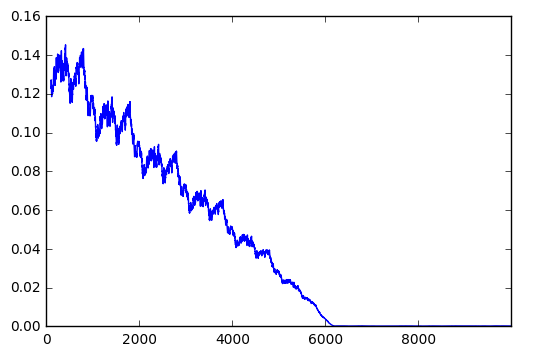

[ 0.0097627   0.04303787] : [ 0.05292178] 0.0528005740599
[ 0.02055268  0.00897664] : [ 0.02961793] 0.0295293118137
[-0.01526904  0.02917882] : [ 0.01396564] 0.0139097824811
[-0.01248256  0.0783546 ] : [ 0.0659563] 0.065872042409
[ 0.09273255 -0.0233117 ] : [ 0.06945009] 0.0694208558654
[ 0.05834501  0.00577898] : [ 0.06421753] 0.0641239915671
[ 0.01360891  0.08511933] : [ 0.09862487] 0.0987282398773
[-0.08579279 -0.08257414] : [-0.16694071] -0.16836692842
[-0.09595632  0.06652397] : [-0.0294298] -0.0294323514023
[ 0.05563135  0.07400243] : [ 0.12914991] 0.129633779839


In [9]:
add = lambda a, b: a+b
add_in = random.uniform(-0.1, +0.1, size=(1000, 2))

learned_add, add_net, add_costs = train_net(add_in, [2, 6, 1], add)

pd.Series(add_costs).rolling(100).mean().plot()
plt.show()

for input in add_in[:10]:
    print(input, ":", learned_add(input), add(*input))

We *need* to add a constant somewhere in the network, otherwise the output must always pass through 0...

In [10]:
def add_basis(inputs, func):
    return np.concatenate([inputs, np.ones(len(inputs))[np.newaxis].T], axis=1), lambda *args: func(*args[:-1])

Cost is 0.021623 at step 0
Cost is 0.001166 at step 2000
Cost is 0.001688 at step 4000
Cost is 0.001717 at step 6000
Cost is 0.002749 at step 8000


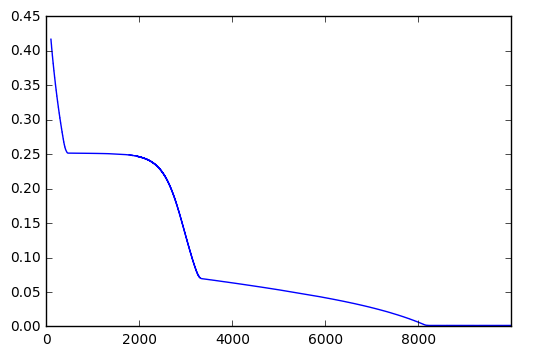

[ 1.  1.  1.] : [ 0.50113381] expected: 0.5 cost: 0.0011338095104
[ 1. -1.  1.] : [-0.49889975] expected: -0.5 cost: 0.00110024520348
[-1.  1.  1.] : [-0.50151462] expected: -0.5 cost: 0.00151461781509
[-1. -1.  1.] : [-0.50036777] expected: -0.5 cost: 0.000367772408922


In [11]:
bools_in = np.array([[+1, +1], [+1, -1], [-1, +1], [-1, -1]], dtype=float)
and_ = lambda a, b: +0.5 if a >= 0 and b >= 0 else -0.5

bools_in, and_ = add_basis(bools_in, and_)

learned_and, and_net, and_costs = train_net(bools_in, [3, 3, 1], and_)

pd.Series(and_costs).rolling(100).mean().plot()
plt.show()

for input in bools_in:
    out = learned_and(input)
    exp_out = and_(*input)
    print(input, ":", out, "expected:", exp_out, "cost:", cost(out, exp_out))

Curiously it doesn't work very nicely for multiplication. Maybe we need to add a basis at each layer?

Obviously it'll work after log normalizing since we got addition right above.

Cost is 0.775600 at step 0
Cost is 0.037663 at step 2000
Cost is 0.260670 at step 4000
Cost is 0.355997 at step 6000
Cost is 0.057340 at step 8000


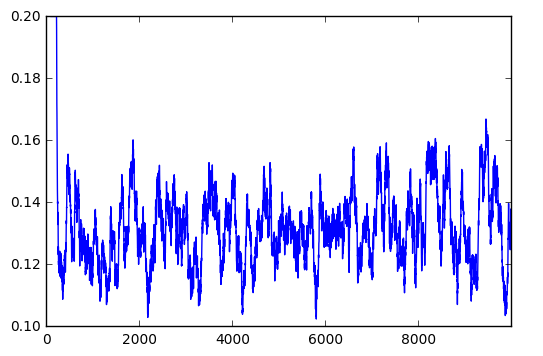

[ 0.0957714  -0.02076309  1.        ] : [ 0.02020954] expected: -0.0994254963684 cost: 0.119635039604
[ 0.02038874 -0.0873262   1.        ] : [ 0.01929392] expected: -0.0890235567742 cost: 0.108317472263
[-0.01802851  0.04450002  1.        ] : [-0.00080227] expected: -0.040113450568 cost: 0.0393111828119
[-0.05225223  0.08876552  1.        ] : [-0.01303686] expected: -0.231909820838 cost: 0.218872957198
[ 0.03735667 -0.04248492  1.        ] : [ 0.01668244] expected: -0.0793547707204 cost: 0.0960372106492
[ 0.05379978 -0.08336705  1.        ] : [ 0.02142637] expected: -0.224256454659 cost: 0.245682826797
[ 0.09495488 -0.09014295  1.        ] : [ 0.02567375] expected: -0.427975661681 cost: 0.453649414889
[ 0.08669118 -0.04942922  1.        ] : [ 0.02198964] expected: -0.214253885329 cost: 0.236243528998
[ 0.05156482 -0.09998526  1.        ] : [ 0.02214005] expected: -0.25778610471 cost: 0.279926158496
[-0.04915198  0.04982012  1.        ] : [-0.00397562] expected: -0.122437885751 cost: 0

In [12]:
mul_in = random.uniform(-0.1, +0.1, size=(10000, 2))
mul = lambda a, b: a*b*50

mul_in, mul = add_basis(mul_in, mul)

# mul_net_shape = [3, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 50, 1]
# mul_net_shape = [3, 1000, 1]
mul_net_shape = [3, 10, 10, 10, 1]
learned_mul, mul_net, mul_costs = train_net(mul_in, mul_net_shape, mul)

pd.Series(mul_costs).rolling(100).mean().clip(upper=0.2).plot()
plt.show()

for input in mul_in[:10]:
    out = learned_mul(input)
    exp_out = mul(*input)
    print(input, ":", out, "expected:", exp_out, "cost:", cost(out, exp_out))